# Deep Learning Models

Authored by [witchapong](https://github.com/witchapong); Edited by [cstorm125](https://github.com/cstorm125/)

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from copy import deepcopy
from utils import *
np.set_printoptions(threshold=50, edgeitems=20)

#torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load Data

In [4]:
train_df = pd.read_csv("train_df.csv")
valid_df = pd.read_csv("valid_df.csv")
submit_df = pd.read_csv("submit_df.csv")
all_df = pd.concat([train_df,valid_df,submit_df],0).reset_index(drop=True)
train_df.shape, valid_df.shape, submit_df.shape

((103112, 9), (14731, 9), (29461, 9))

In [5]:
train_df.head()

,date,org,prev_snap_1,prev_snap_2,prev_snap_3,prev_snap_4,project,target_snap,user
0,2014-12-05,4,0,0,0,0,145,195,59
1,2014-12-05,4,178,195,0,0,145,240,59
2,2014-12-05,4,195,0,0,0,145,178,59
3,2015-02-10,4,240,223,88,0,414,195,59
4,2015-02-10,4,88,0,0,0,414,223,59


In [6]:
train_df.describe()

,org,prev_snap_1,prev_snap_2,prev_snap_3,prev_snap_4,project,target_snap,user
count,103112.000000,103112.000000,103112.000000,103112.000000,103112.000000,103112.000000,103112.000000,103112.000000
mean,2.290994,196.070661,141.378404,94.487072,56.880169,197.992271,282.422347,117.850114
std,0.755975,145.820540,153.465324,142.909668,119.606031,95.240417,128.184887,57.546317
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2.000000,18.000000,0.000000,0.000000,0.000000,170.000000,212.000000,82.000000
50%,2.000000,240.000000,88.000000,0.000000,0.000000,170.000000,240.000000,90.000000
75%,2.000000,279.000000,240.000000,224.000000,0.000000,170.000000,416.000000,192.000000
max,4.000000,485.000000,485.000000,485.000000,485.000000,506.000000,485.000000,217.000000


## Cross-sectional Model

### Dataloaders

In [7]:
class SnapStaDataset(Dataset):
    def __init__(self, df, sta_cols, target_col):
        self.df  = df
        self.sta = df[sta_cols]
        self.target = df[target_col]

    def __getitem__(self, index):
        return(torch.tensor(self.sta.iloc[index], dtype=torch.long, device=device),
               torch.tensor(self.target[index], dtype=torch.long, device=device))

    def __len__(self):
        return(self.df.shape[0])

In [8]:
sta_cols = ['prev_snap_4', 'prev_snap_3', 'prev_snap_2', 'prev_snap_1','org','project','user']
target_col = 'target_snap'

bs = 1024
train_ds = SnapStaDataset(train_df, sta_cols, target_col)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
valid_ds = SnapStaDataset(valid_df, sta_cols, target_col)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False, num_workers=4)

In [9]:
next(iter(train_dl))

[tensor([[  0,   0, 214,  ...,   2, 170, 192],
         [  0,   0, 416,  ...,   2, 170,  31],
         [  0, 240, 317,  ...,   2, 170,  90],
         ...,
         [214, 262, 279,  ...,   2, 170,  90],
         [  0,   0,   0,  ...,   2, 170,  90],
         [  0, 240, 202,  ...,   2, 170, 192]]),
 tensor([279, 209, 240,  ..., 368, 229, 461])]

### Architecture

In [10]:
sta_dict = {'prev_snap_4': 486, 'prev_snap_3': 486, 'prev_snap_2': 486, 'prev_snap_1': 486,
            'org':5, 'project':507, 'user':218}
config = {'emb_p': 0.05, 'fc_ps': [0.5, 0.25],'fc_szs': [1000, 500],  'out_sz': 486}

#rule of thump for choosing embedding size from fastai
def emb_sz_rule(n_cat): return min(600, round(1.6 * n_cat**0.56))

class RecommendSta(nn.Module):
    def __init__(self, config, sta_dict):
        super(RecommendSta, self).__init__()
        #set parameters
        self.sta_dict = sta_dict
        self.emb_p = config['emb_p']
        self.fc_szs = config['fc_szs']
        self.fc_ps = config['fc_ps']
        self.out_sz = config['out_sz']
        
        #embedding layers
        self.emb_drop = nn.Dropout(self.emb_p)
        self.sta_layers = nn.ModuleList([nn.Embedding(sta_dict[i], emb_sz_rule(sta_dict[i])) for i in sta_dict])
        self.lin_in = sum([emb_sz_rule(sta_dict[i]) for i in sta_dict])
        self.fc_szs = [self.lin_in] + self.fc_szs
        
        #fully connected layers
        fc_layers_list = []
        for ni,nf,p in zip(self.fc_szs[:-1], self.fc_szs[1:], self.fc_ps):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        #output head
        self.head = torch.nn.Linear(in_features=self.fc_szs[-1], out_features=self.out_sz)

    def forward(self, sta_input):
        #sta
        sta_list = [e(sta_input[:,i]) for i,e in enumerate(self.sta_layers)]
        sta_out = torch.cat(sta_list,1)
        sta_out = self.emb_drop(sta_out)
        
        #linear
        res = self.fc_layers(sta_out)
        res = self.head(res)
    
        return(res)

In [11]:
model = RecommendSta(config, sta_dict)
x = next(iter(valid_dl))
sta_input = x[0]
target = x[1]
model(sta_input).shape

torch.Size([14731, 486])

In [12]:
model

RecommendSta(
  (emb_drop): Dropout(p=0.05)
  (sta_layers): ModuleList(
    (0): Embedding(486, 51)
    (1): Embedding(486, 51)
    (2): Embedding(486, 51)
    (3): Embedding(486, 51)
    (4): Embedding(5, 4)
    (5): Embedding(507, 52)
    (6): Embedding(218, 33)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=293, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
  )
  (head): Linear(in_features=500, out_features=486, bias=True)
)

### Training

In [26]:
sta_cols = ['prev_snap_4', 'prev_snap_3', 'prev_snap_2', 'prev_snap_1','org','project','user']
target_col = 'target_snap'

bs = 1024
train_ds = SnapStaDataset(train_df, sta_cols, target_col)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
valid_ds = SnapStaDataset(valid_df, sta_cols, target_col)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False, num_workers=4)

In [27]:
sta_dict = {'prev_snap_4': 486, 'prev_snap_3': 486, 'prev_snap_2': 486, 'prev_snap_1': 486,
            'org':5, 'project':507, 'user':218}
config = {'emb_p': 0.05, 'fc_ps': [0.5, 0.25],'fc_szs': [1000, 500],  'out_sz': 486}

model = RecommendSta(config, sta_dict).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

In [28]:
train_losses = []
valid_losses = []
lrs = []
accs = []
acc_ks = []
best_loss = np.inf
best_weights = None
no_improvements = 0

for epoch in tqdm_notebook(range(20)):
    #current lr
    lr = scheduler.optimizer.param_groups[0]['lr']
    lrs.append(lr)
    #train
    train_loss = []
    model.train()
    for x in train_dl:
        sta_input = x[0]
        target = x[1]
        
        #forward
        score = model(sta_input)
        
        #loss
        loss = loss_function(score,target)
        train_loss.append(loss.item())
        
        
        #step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(train_loss))
    
    #validate
    model.eval()
    for x in valid_dl:
        sta_input = x[0]
        target = x[1]
        
        #forward
        score = model(sta_input)
        
        #loss
        valid_loss = loss_function(score,target)
        valid_losses.append(valid_loss.item())
        
        #accuracy
        y = target.detach().numpy()
        probs = F.softmax(score,1).detach().numpy()
        
        #top 1 accuracy
        preds = probs.argmax(1)
        acc = (preds==y).mean()
        accs.append(acc)
        
        #top k accuracy
        acc_k = score_topk_probs(probs,y,k=5)
        acc_ks.append(acc_k)
        
    #choose best model
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1

    #early stopping
    if no_improvements > 2:
        print(f'early stopping after epoch {epoch}')
        break
        
    #end of epoch
    scheduler.step(valid_loss)
    print(f'{epoch} train loss: {round(np.mean(train_loss),3)} valid loss: {round(valid_loss.item(),3)}\
            accuracy: {round(acc,3)}  top-5 accuracy: {round(acc_k,3)}')

0 train loss: 2.863 valid loss: 2.374            accuracy: 0.431  top-5 accuracy: 0.745
1 train loss: 2.281 valid loss: 2.192            accuracy: 0.443  top-5 accuracy: 0.77
2 train loss: 2.115 valid loss: 2.109            accuracy: 0.463  top-5 accuracy: 0.787
3 train loss: 2.025 valid loss: 2.092            accuracy: 0.468  top-5 accuracy: 0.784
4 train loss: 1.963 valid loss: 2.065            accuracy: 0.484  top-5 accuracy: 0.793
5 train loss: 1.913 valid loss: 2.074            accuracy: 0.478  top-5 accuracy: 0.792
6 train loss: 1.878 valid loss: 2.028            accuracy: 0.487  top-5 accuracy: 0.8
7 train loss: 1.851 valid loss: 2.02            accuracy: 0.489  top-5 accuracy: 0.802
8 train loss: 1.824 valid loss: 2.018            accuracy: 0.491  top-5 accuracy: 0.8
9 train loss: 1.799 valid loss: 2.008            accuracy: 0.494  top-5 accuracy: 0.803
10 train loss: 1.786 valid loss: 2.026            accuracy: 0.488  top-5 accuracy: 0.798
11 train loss: 1.77 valid loss: 2.025

In [29]:
#save model
# torch.save(best_weights,'sta_weights.pth')

### Diagnostics

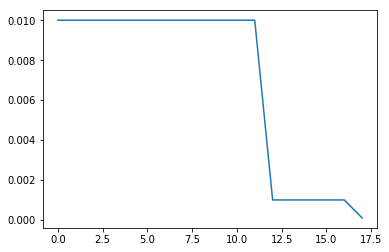

In [30]:
plt.plot(lrs)

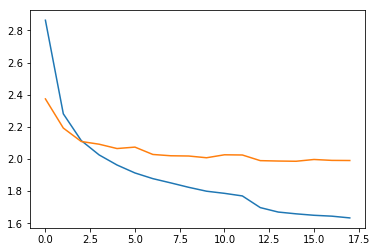

In [31]:
plt.plot(train_losses)
plt.plot(valid_losses)

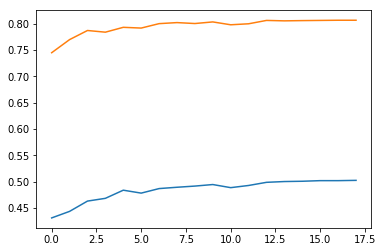

In [32]:
plt.plot(accs)
plt.plot(acc_ks)

### Evaluations

With 486 target classes, it is almost impossible to diagnose how well your model performs by looking at confusion matrix like you would normally do. Here we provide the idea of an "accuracy curve" as possible model evaluation tool.

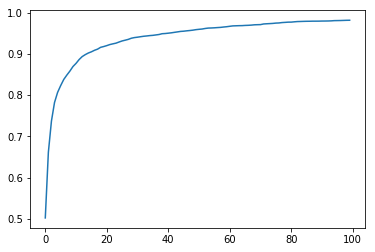

In [38]:
#accurayc curve
acc_curve = []
for i in tqdm_notebook(range(1,101)):
    acc_curve.append(score_topk_probs(probs,y,k=i))
plt.plot(acc_curve)

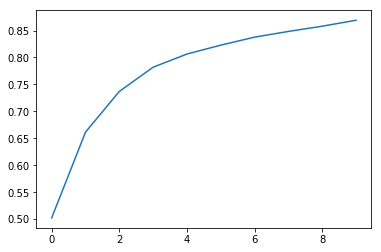

In [39]:
plt.plot(acc_curve[:10])

## Sequential Model

Treat `prev_snap_4` to `prev_snap_1` as sequential categorical features, and put them through recurrent layers.

### Dataloaders

In [92]:
class SnapSeqDataset(Dataset):
    def __init__(self, df, seq_cols, sta_cols, target_col):
        self.df  = df
        self.seq = df[seq_cols]
        self.sta = df[sta_cols]
        self.target = df[target_col]

    def __getitem__(self, index):
        return(torch.tensor(self.seq.iloc[index], dtype=torch.long, device=device),
               torch.tensor(self.sta.iloc[index], dtype=torch.long, device=device),
               torch.tensor(self.target[index], dtype=torch.long, device=device))

    def __len__(self):
        return(self.df.shape[0])

In [93]:
seq_cols = ['prev_snap_4', 'prev_snap_3', 'prev_snap_2', 'prev_snap_1',]
sta_cols = ['org','project','user']
target_col = 'target_snap'

bs = 1024
train_ds = SnapSeqDataset(train_df, seq_cols, sta_cols, target_col)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
valid_ds = SnapSeqDataset(valid_df, seq_cols, sta_cols, target_col)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False, num_workers=4)

In [94]:
next(iter(train_dl))

[tensor([[197, 197, 240, 444],
         [  0,   0,   0, 240],
         [ 38, 398, 398, 149],
         ...,
         [  0,   0,   0, 214],
         [  0,   0,   0,   0],
         [  0,   0,   0, 363]]), tensor([[  2, 170,  90],
         [  2, 170,  82],
         [  2, 170, 192],
         ...,
         [  4, 363, 115],
         [  2, 170, 192],
         [  2, 170, 192]]), tensor([197, 196, 461,  ..., 240, 364, 279])]

### Architecture

In [98]:
sta_dict = {'org':5, 'project':507, 'user':218}
seq_dim = 486
config = {'emb_p': 0.05, 
          'rnn_p':0., 'rnn_l':1, 'rnn_h':1000, 'seq_len': 4,
          'fc_ps': [0.5, 0.25],'fc_szs': [1000, 500], 
          'out_sz': 486}

#rule of thump for choosing embedding size from fastai
def emb_sz_rule(n_cat): return min(600, round(1.6 * n_cat**0.56))

class RecommendSeq(nn.Module):
    def __init__(self, config, sta_dict, seq_dim):
        super(RecommendSeq, self).__init__()
        #set parameters
        self.sta_dict = sta_dict
        self.seq_dim = seq_dim
        self.emb_p = config['emb_p']
        self.rnn_p = config['rnn_p']
        self.rnn_l = config['rnn_l']
        self.rnn_h = config['rnn_h']
        self.seq_len = config['seq_len']
        self.fc_szs = config['fc_szs']
        self.fc_ps = config['fc_ps']
        self.out_sz = config['out_sz']
        
        #embedding layers
        self.emb_drop = nn.Dropout(self.emb_p)
        self.sta_layers = nn.ModuleList([nn.Embedding(sta_dict[i], emb_sz_rule(sta_dict[i])) for i in sta_dict])
        self.seq_layer = nn.Embedding(seq_dim, emb_sz_rule(seq_dim))
        self.lin_in = sum([emb_sz_rule(sta_dict[i]) for i in sta_dict]) + self.rnn_h * self.seq_len
        self.fc_szs = [self.lin_in] + self.fc_szs
        
        #recurrent layers
        self.rnn_layers = nn.LSTM(emb_sz_rule(seq_dim), self.rnn_h,
                                   num_layers = self.rnn_l, bias=True,
                                   dropout=self.rnn_p)
        
        #fully connected layers
        fc_layers_list = []
        for ni,nf,p in zip(self.fc_szs[:-1], self.fc_szs[1:], self.fc_ps):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        #output head
        self.head = torch.nn.Linear(in_features=self.fc_szs[-1], out_features=self.out_sz)

    def forward(self, seq_input, sta_input):
        #sta
        sta_list = [e(sta_input[:,i]) for i,e in enumerate(self.sta_layers)]
        sta_out = torch.cat(sta_list,1)
        sta_out = self.emb_drop(sta_out)
        
        #seq
        bs = seq_input.shape[0]
        seq_out = self.seq_layer(seq_input)
        seq_out = self.emb_drop(seq_out).permute(1,0,2)
        seq_out, seq_h = self.rnn_layers(seq_out)
        seq_out = seq_out.reshape(bs,-1)
        
        #linear
        lin_in = torch.cat([sta_out,seq_out],1)
        res = self.fc_layers(lin_in)
        res = self.head(res)
        
        return(res)

In [99]:
model = RecommendSeq(config, sta_dict, seq_dim)
x = next(iter(valid_dl))
seq_input = x[0]
sta_input = x[1]
target = x[2]
model(seq_input,sta_input).shape

torch.Size([14731, 486])

In [100]:
model

RecommendSeq(
  (emb_drop): Dropout(p=0.05)
  (sta_layers): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(507, 52)
    (2): Embedding(218, 33)
  )
  (seq_layer): Embedding(486, 51)
  (rnn_layers): LSTM(51, 1000)
  (fc_layers): Sequential(
    (0): Linear(in_features=4089, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
  )
  (head): Linear(in_features=500, out_features=486, bias=True)
)

### Training

In [101]:
seq_cols = ['prev_snap_4', 'prev_snap_3', 'prev_snap_2', 'prev_snap_1',]
sta_cols = ['org','project','user']
target_col = 'target_snap'

bs = 1024
train_ds = SnapSeqDataset(train_df, seq_cols, sta_cols, target_col)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
valid_ds = SnapSeqDataset(valid_df, seq_cols, sta_cols, target_col)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False, num_workers=4)

In [103]:
sta_dict = {'org':5, 'project':507, 'user':218}
seq_dim = 486
config = {'emb_p': 0.05, 
          'rnn_p':0., 'rnn_l':1, 'rnn_h':1000, 'seq_len': 4,
          'fc_ps': [0.5, 0.25],'fc_szs': [1000, 500], 
          'out_sz': 486}

model = RecommendSeq(config, sta_dict, seq_dim).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

In [ ]:
train_losses = []
valid_losses = []
lrs = []
accs = []
acc_ks = []
best_loss = np.inf
best_weights = None
no_improvements = 0

for epoch in tqdm_notebook(range(20)):
    #current lr
    lr = scheduler.optimizer.param_groups[0]['lr']
    lrs.append(lr)
    #train
    train_loss = []
    model.train()
    for x in train_dl:
        seq_input = x[0]
        sta_input = x[1]
        target = x[2]
        
        #forward
        score = model(seq_input,sta_input)
        
        #loss
        loss = loss_function(score,target)
        train_loss.append(loss.item())
        
        #step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(np.mean(train_loss))
    
    #validate
    model.eval()
    for x in valid_dl:
        seq_input = x[0]
        sta_input = x[1]
        target = x[2]
        
        #forward
        score = model(seq_input,sta_input)
        
        #loss
        valid_loss = loss_function(score,target)
        valid_losses.append(valid_loss.item())
        
        #accuracy
        y = target.detach().numpy()
        probs = F.softmax(score,1).detach().numpy()
        
        #top 1 accuracy
        preds = probs.argmax(1)
        acc = (preds==y).mean()
        accs.append(acc)
        
        #top k accuracy
        acc_k = score_topk_probs(probs,y,k=5)
        acc_ks.append(acc_k)
        
    #choose best model
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1

    #early stopping
    if no_improvements > 2:
        print(f'early stopping after epoch {epoch}')
        break
        
    #end of epoch
    scheduler.step(valid_loss)
    print(f'{epoch} train loss: {round(np.mean(train_loss),3)} valid loss: {round(valid_loss.item(),3)}\
            accuracy: {round(acc,3)}  top-5 accuracy: {round(acc_k,3)}')